In [ ]:
import pandas as pd



train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")


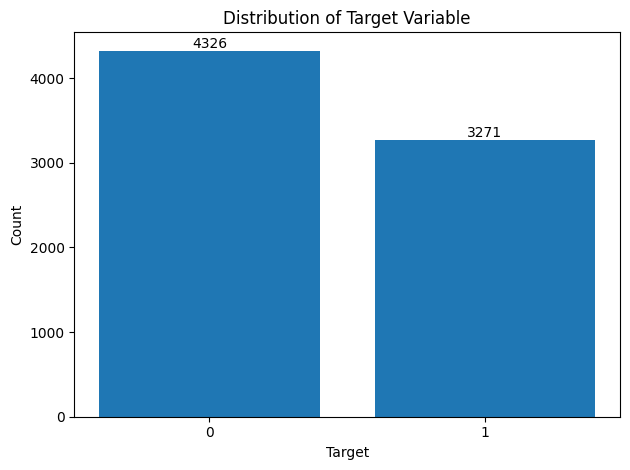

In [22]:
import matplotlib.pyplot as plt


# Count the 0s and 1s
counts = train['target'].value_counts().sort_index()

# Make the plot
fig, ax = plt.subplots()
bars = ax.bar(['0', '1'], counts.values)

# Add count labels above the bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            str(int(bar.get_height())),
            ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

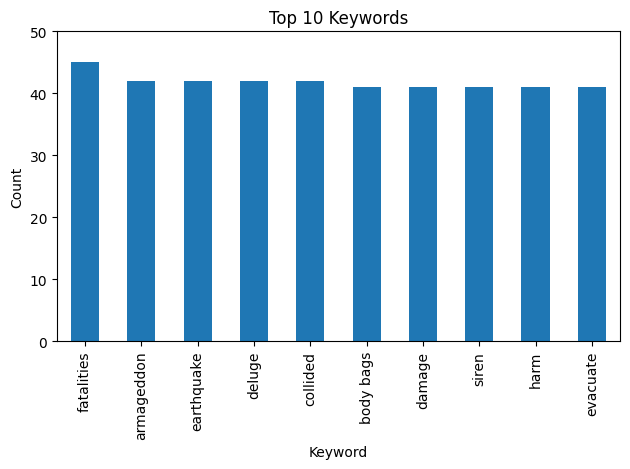

In [23]:
import matplotlib.pyplot as plt

top10 = train['keyword'].value_counts().head(10)
top10.plot(kind='bar')
plt.title("Top 10 Keywords")
plt.ylim(0, 50)
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
from urllib.parse import unquote 

mask = train['keyword'].str.contains('%', na=False)
train.loc[mask, 'keyword'] = train.loc[mask, 'keyword'].apply(unquote)

In [ ]:
import pandas as pd
from pathlib import Path

missing_mask = train['keyword'].isna() | train['keyword'].str.strip().eq('')
print(f"Missing keywords: {missing_mask.sum()} / {len(train)}")

In [ ]:
import re, warnings, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#flag rows that already have a keyword vs. blanks
mask_missing = train['keyword'].isna() | train['keyword'].str.strip().eq('')
mask_known   = ~mask_missing

X_train = train.loc[mask_known, 'text']
y_train = train.loc[mask_known, 'keyword']

#Encode string labels to integers 
le   = LabelEncoder()
y_enc = le.fit_transform(y_train)

#text feature extractors
#catch hashtags, typos
word_vect = TfidfVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2), max_features=25_000,
                            dtype=np.float32)

char_vect = TfidfVectorizer(analyzer='char', ngram_range=(3, 5),
                            min_df=3, max_features=40_000,
                            dtype=np.float32)

# combine
feats = FeatureUnion([('word', word_vect), ('char', char_vect)])

#classifier -  (SGD logistic regression on sparse data)
sgd = SGDClassifier(loss='log_loss',             # logistic-reg loss
                    penalty='l2',
                    class_weight='balanced',     
                    max_iter=5_000,
                    n_jobs=-1,
                    random_state=42)

pipe = Pipeline([('feats', feats), ('clf', sgd)])

# grid-search over alpha 
param_grid = {'clf__alpha': [0.0001, 0.00005, 0.00001]}  # decimal form
with warnings.catch_warnings():
    warnings.simplefilter('ignore')          
    gs = GridSearchCV(pipe, param_grid,
                      cv=3, scoring='accuracy',
                      n_jobs=-1, verbose=0)
    gs.fit(X_train, y_enc)

pipe_best = gs.best_estimator_
print(f"SGD best CV accuracy: {gs.best_score_:.3f}")

#predict on the blank rows, keep confident matches
X_blank = train.loc[mask_missing, 'text'].fillna("")
proba   = pipe_best.predict_proba(X_blank.tolist())
pred_id = proba.argmax(1)
pred_kw = le.inverse_transform(pred_id)
conf    = proba.max(1)

THRESH = 0.10                              # prob
good_rows, good_kw = [], []

for i, (kw, p) in enumerate(zip(pred_kw, conf)):
    if p < THRESH:
        continue                           # skip low-confidence
    txt = str(X_blank.iloc[i]).lower()
    if kw in txt or kw.replace(' ', '') in txt:
        good_rows.append(i)
        good_kw.append(kw)

# write back accepted model labels
indices = mask_missing[mask_missing].index[good_rows]
train.loc[indices, 'keyword'] = good_kw
print(f"Model filled {len(indices)} of {mask_missing.sum()} blanks.")

# heuristic fallback (hashtags + small disaster vocab)
still_blank = train['keyword'].isna() | train['keyword'].str.strip().eq('')
if still_blank.any():
    TAG_RE = re.compile(r'#([A-Za-z0-9_]+)')
    VOCAB  = {
        'earthquake','flood','fire','wildfire','hurricane','tornado',
        'storm','explosion','evacuation','drought','heatwave','cyclone',
        'eruption','volcano','tsunami','landslide','collision','damage',
        'thunderstorm','hail','blizzard','quarantine','smoke','sirens',
        'aftershock','mudslide','ice','lightning','burst','collapse'
    }

    def heuristic(text: str):
        t = text.lower()
        #prefer hashtags
        tags = TAG_RE.findall(t)
        if tags:
            return tags[0]
        #else first vocab word present
        for w in re.findall(r'[a-z]+', t):
            if w in VOCAB:
                return w
        return np.nan

    filled_h = train.loc[still_blank, 'text'].apply(heuristic)
    n_h      = filled_h.notna().sum()
    train.loc[still_blank, 'keyword'] = filled_h
    print(f"Heuristic filled {n_h} additional blanks.")

# final tally
total_filled = (mask_missing & train['keyword'].notna()).sum()
print(f"\nTotal blanks filled: {total_filled} / {mask_missing.sum()} "
      f"({total_filled/mask_missing.sum():.1%})")

In [ ]:
#remove rows with empty keywords after
train = train[train['keyword'].notna() & train['keyword'].str.strip().ne('')].copy()

In [ ]:
import re, warnings, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#flag rows that already have a keyword vs. blanks
mask_missing = test['keyword'].isna() | test['keyword'].str.strip().eq('')
mask_known   = ~mask_missing

X_test = test.loc[mask_known, 'text']
y_test = test.loc[mask_known, 'keyword']

#Encode string labels to integers 
le   = LabelEncoder()
y_enc = le.fit_transform(y_test)

#text feature extractors
 
word_vect = TfidfVectorizer(lowercase=True, stop_words='english',
                            ngram_range=(1, 2), max_features=25_000,
                            dtype=np.float32)

char_vect = TfidfVectorizer(analyzer='char', ngram_range=(3, 5),
                            min_df=3, max_features=40_000,
                            dtype=np.float32)

# combine
feats = FeatureUnion([('word', word_vect), ('char', char_vect)])

#classifier -  (SGD logistic regression on sparse data)
sgd = SGDClassifier(loss='log_loss',             # logistic-reg loss
                    penalty='l2',
                    class_weight='balanced',     
                    max_iter=5_000,
                    n_jobs=-1,
                    random_state=42)

pipe = Pipeline([('feats', feats), ('clf', sgd)])

# grid-search over alpha 
param_grid = {'clf__alpha': [0.0001, 0.00005, 0.00001]}  # decimal form
with warnings.catch_warnings():
    warnings.simplefilter('ignore')          
    gs = GridSearchCV(pipe, param_grid,
                      cv=3, scoring='accuracy',
                      n_jobs=-1, verbose=0)
    gs.fit(X_test, y_enc)

pipe_best = gs.best_estimator_
print(f"SGD best CV accuracy: {gs.best_score_:.3f}")

#predict on the blank rows, keep confident matches
X_blank = test.loc[mask_missing, 'text'].fillna("")
proba   = pipe_best.predict_proba(X_blank.tolist())
pred_id = proba.argmax(1)
pred_kw = le.inverse_transform(pred_id)
conf    = proba.max(1)

THRESH = 0.10                              # prob
good_rows, good_kw = [], []

for i, (kw, p) in enumerate(zip(pred_kw, conf)):
    if p < THRESH:
        continue                           # skip low-confidence
    txt = str(X_blank.iloc[i]).lower()
    if kw in txt or kw.replace(' ', '') in txt:
        good_rows.append(i)
        good_kw.append(kw)

# write back accepted model labels
indices = mask_missing[mask_missing].index[good_rows]
test.loc[indices, 'keyword'] = good_kw
print(f"Model filled {len(indices)} of {mask_missing.sum()} blanks.")

#heuristic fallback (hashtags + small disaster vocab)
still_blank = test['keyword'].isna() | test['keyword'].str.strip().eq('')
if still_blank.any():
    TAG_RE = re.compile(r'#([A-Za-z0-9_]+)')
    VOCAB  = {
        'earthquake','flood','fire','wildfire','hurricane','tornado',
        'storm','explosion','evacuation','drought','heatwave','cyclone',
        'eruption','volcano','tsunami','landslide','collision','damage',
        'thunderstorm','hail','blizzard','quarantine','smoke','sirens',
        'aftershock','mudslide','ice','lightning','burst','collapse'
    }

    def heuristic(text: str):
        t = text.lower()
        #prefer hashtags
        tags = TAG_RE.findall(t)
        if tags:
            return tags[0]
        #else first vocab word present
        for w in re.findall(r'[a-z]+', t):
            if w in VOCAB:
                return w
        return np.nan

    filled_h = test.loc[still_blank, 'text'].apply(heuristic)
    n_h      = filled_h.notna().sum()
    test.loc[still_blank, 'keyword'] = filled_h
    print(f"Heuristic filled {n_h} additional blanks.")

# final tally
total_filled = (mask_missing & test['keyword'].notna()).sum()
print(f"\nTotal blanks filled: {total_filled} / {mask_missing.sum()} "
      f"({total_filled/mask_missing.sum():.1%})")

In [ ]:
miss = train['location'].isna() | train['location'].str.strip().eq('')
print(f"Missing locations: {miss.mean():.1%}  ({miss.sum()} / {len(train)})")

In [ ]:
train = train.drop("location", axis=1)
test = test.drop("location", axis=1)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

train["text"] = train["text"].fillna("")
test["text"] = test["text"].fillna("")
train["keyword"] = train["keyword"].fillna("unknown")
test["keyword"] = test["keyword"].fillna("unknown")


X_train = train[["text", "keyword"]]
y_train = train["target"]
X_test = test[["text", "keyword"]]

text_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
])

keyword_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer())
])

preprocessor = ColumnTransformer([
    ("text", text_transformer, "text"),
    ("keyword", keyword_transformer, "keyword"),
])

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
test_preds = pipeline.predict(X_test)

test["target"] = test_preds
test[["id", "target"]].to_csv("data/submission1.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

# Fill missing values
train["text"] = train["text"].fillna("")
test["text"] = test["text"].fillna("")
train["keyword"] = train["keyword"].fillna("unknown")
test["keyword"] = test["keyword"].fillna("unknown")

# Define features and target
X_train = train[["text", "keyword"]]
y_train = train["target"]
X_test = test[["text", "keyword"]]

# Text and keyword pipelines
text_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
])

keyword_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer())
])

# Combine transformations
preprocessor = ColumnTransformer([
    ("text", text_transformer, "text"),
    ("keyword", keyword_transformer, "keyword"),
])

# Final pipeline with Random Forest
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict on test data
test_preds = pipeline.predict(X_test)

# Save results
test["target"] = test_preds
test[["id", "target"]].to_csv("data/submission_rf.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
import os

# Fill missing values
train["text"] = train["text"].fillna("")
test["text"] = test["text"].fillna("")
train["keyword"] = train["keyword"].fillna("unknown")
test["keyword"] = test["keyword"].fillna("unknown")

# Define features and target
X_train = train[["text", "keyword"]]
y_train = train["target"]
X_test = test[["text", "keyword"]]

# Text and keyword pipelines
text_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
])

keyword_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer())
])

# Combine transformations
preprocessor = ColumnTransformer([
    ("text", text_transformer, "text"),
    ("keyword", keyword_transformer, "keyword"),
])

# Final pipeline with XGBoost
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(eval_metric="logloss", random_state=42))

])

# Train model
pipeline.fit(X_train, y_train)

# Predict on test data
test_preds = pipeline.predict(X_test)

# Ensure folder exists
os.makedirs("data", exist_ok=True)

# Save results
test["target"] = test_preds
test[["id", "target"]].to_csv("data/submission_xgb.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
import os

# Fill missing values
train["text"] = train["text"].fillna("")
test["text"] = test["text"].fillna("")
train["keyword"] = train["keyword"].fillna("unknown")
test["keyword"] = test["keyword"].fillna("unknown")

# Define features and target
X_train = train[["text", "keyword"]]
y_train = train["target"]
X_test = test[["text", "keyword"]]

# Text and keyword pipelines
text_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=10000)),
])

keyword_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer())
])

# Combine transformations
preprocessor = ColumnTransformer([
    ("text", text_transformer, "text"),
    ("keyword", keyword_transformer, "keyword"),
])

# Final pipeline with Naive Bayes
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", MultinomialNB())
])

# Train model
pipeline.fit(X_train, y_train)

# Predict on test data
test_preds = pipeline.predict(X_test)

# Ensure folder exists
os.makedirs("data", exist_ok=True)

# Save results
test["target"] = test_preds
test[["id", "target"]].to_csv("data/submission_nb.csv", index=False)

In [ ]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import os
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

#Prepare data
train["text"] = train["text"].fillna("")
test["text"] = test["text"].fillna("")
train_texts = train["text"].tolist()
train_labels = train["target"].tolist()

#Load tokeniser and model 
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenise inputs
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# Create HuggingFace Dataset
train_dataset = Dataset.from_pandas(train[["text", "target"]])
train_dataset = train_dataset.rename_columns({"target": "label"})
train_dataset = train_dataset.map(preprocess, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 5. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=False,
    per_device_train_batch_size=32, 
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=5000,
    seed=42,
    disable_tqdm=True
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()

# Predict on test set
test_dataset = Dataset.from_pandas(test[["text"]])
test_dataset = test_dataset.map(preprocess, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Run inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

predictions = []
with torch.no_grad():
    for batch in torch.utils.data.DataLoader(test_dataset, batch_size=32):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# Save results
test["target"] = predictions
os.makedirs("data", exist_ok=True)
test[["id", "target"]].to_csv("data/submission_distilbert.csv", index=False)

